In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN, CircuitQNN
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import numpy as np
import pandas as pd

import copy
from collections import namedtuple
import os
from dotenv import load_dotenv
import sys
import random
import shutil
import time

In [2]:
try:
    provider = IBMProvider()
except:
    load_dotenv('../../.env')
    IBMProvider.save_account(token=os.environ.get('IBMQ_TOKEN'))
    provider = IBMProvider()

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
BACKEND = provider.get_backend('ibmq_qasm_simulator')
# backend = least_busy(
#     provider.backends(
#         simulator=False, filters=lambda b: b.configuration().n_qubits == 4
#     )
# )

In [4]:
TRAIN_RATIO = 0.8

ROOT = os.path.join('..', '..')
data_dir = os.path.join(ROOT, 'input')
images_dir = os.path.join(data_dir, 'Data')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
output_dir = os.path.join(ROOT, 'outputs')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(train_dir, exist_ok = True)
os.makedirs(test_dir, exist_ok = True)
os.makedirs(output_dir, exist_ok = True)

classes = os.listdir(images_dir)

for c in classes:
    class_dir = os.path.join(images_dir, c)
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        shutil.copyfile(image_src, image_dst)
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        shutil.copyfile(image_src, image_dst)

In [5]:
train_data = datasets.ImageFolder(root = train_dir, transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.2099, 0.2099, 0.2099])
Calculated stds: tensor([0.1901, 0.1901, 0.1901])


In [6]:
np.array(means)

array([0.20992513, 0.20992513, 0.20992513], dtype=float32)

In [7]:
pretrained_size = 256
pretrained_means = [0.2099, 0.2099, 0.2099]
pretrained_stds= [0.1901, 0.1901, 0.1901]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [8]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [9]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [10]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 2227
Number of validation examples: 248
Number of testing examples: 621


In [12]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [13]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

In [14]:
def plot_images(images, labels, classes, normalize = True):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

In [15]:
# N_IMAGES = 25

# images, labels = zip(*[(image, label) for image, label in 
#                            [train_data[i] for i in range(N_IMAGES)]])

# classes = test_data.classes
# plot_images(images, labels, classes)

In [16]:
# images[0].shape

In [17]:
def parity(x):
    return "{:b}".format(x).count("1") % 2

def create_qnn(output_dim, backend):
    feature_map = ZZFeatureMap(output_dim)
    ansatz = RealAmplitudes(output_dim, reps=1)
    qc = QuantumCircuit(output_dim)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # qnn = EstimatorQNN(
    #     circuit=qc,
    #     input_params=feature_map.parameters,
    #     weight_params=ansatz.parameters,
    #     input_gradients=True,
    # )
    # qnn = SamplerQNN(
    #     circuit=qc,
    #     input_params=feature_map.parameters,
    #     weight_params=ansatz.parameters,
    #     interpret=parity,
    #     output_shape=output_dim,
    #     sampler=Sampler(),
    # )
    qnn = CircuitQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        interpret=parity,
        output_shape=output_dim,
        quantum_instance=backend,
    )
    return qnn

In [18]:
class AlexNetQNN(nn.Module):
    def __init__(self, output_dim, backend=None, is_qnn=True):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 16 * 16, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

        self.is_qnn = is_qnn
        self.qantum_features = nn.Sequential(
            TorchConnector(create_qnn(output_dim, backend)),
            # nn.Linear(1, 4),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        if self.is_qnn:
            x = self.qantum_features(x)
        return torch.cat((x, 1 - x), -1), h

In [19]:
is_qnn = True
if is_qnn:
    MODEL_NAME = 'alexnet_qnn'
else:
    MODEL_NAME = 'alexnet'

model = AlexNetQNN(len(classes), BACKEND, is_qnn=is_qnn)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 287,488,844 trainable parameters


In [21]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [22]:
model.apply(initialize_parameters)

AlexNetQNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=65536, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5

In [23]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)
device = torch.device('cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [24]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), os.path.join(output_dir, 'init_params.pt'))

    def range_test(self, iterator, end_lr = 10, num_iter = 100, smooth_f = 0.05, diverge_th = 5):
        lrs = []
        losses = []
        best_loss = float('inf')
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):
            loss = self._train_batch(iterator)

            lr_scheduler.step()
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]          
            if loss < best_loss:
                best_loss = loss
            losses.append(loss)      
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load(os.path.join(output_dir, 'init_params.pt')))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        self.model.train()
        self.optimizer.zero_grad()
        x, y = iterator.get_batch()
        x = x.to(self.device)
        y = y.to(self.device)
        y_pred, _ = self.model(x)  
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [25]:
END_LR = 10
NUM_ITER = 100

# lr_finder = LRFinder(model, optimizer, criterion, device)
# lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

In [26]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

In [27]:
# plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [28]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

In [29]:
EPOCHS = 2
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [30]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [31]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(output_dir, f'{MODEL_NAME}.pt'))

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load(os.path.join(output_dir, f'{MODEL_NAME}.pt')))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Test Loss: 1.384 | Test Acc: 22.66%


In [ ]:
def get_predictions(model, iterator, device):
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)

            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

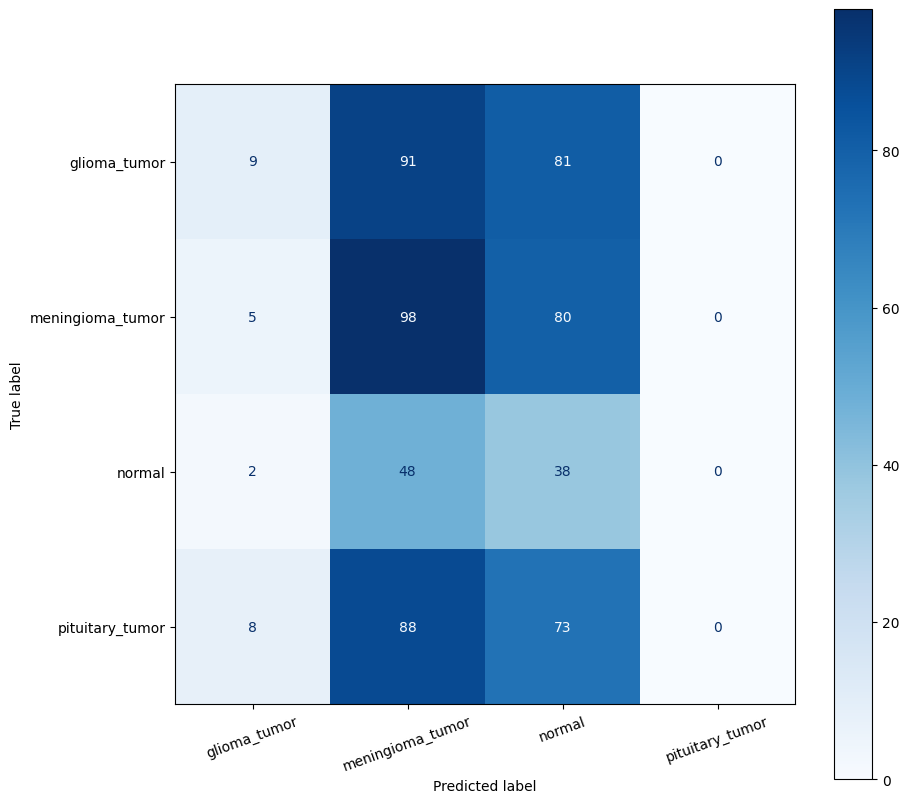

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

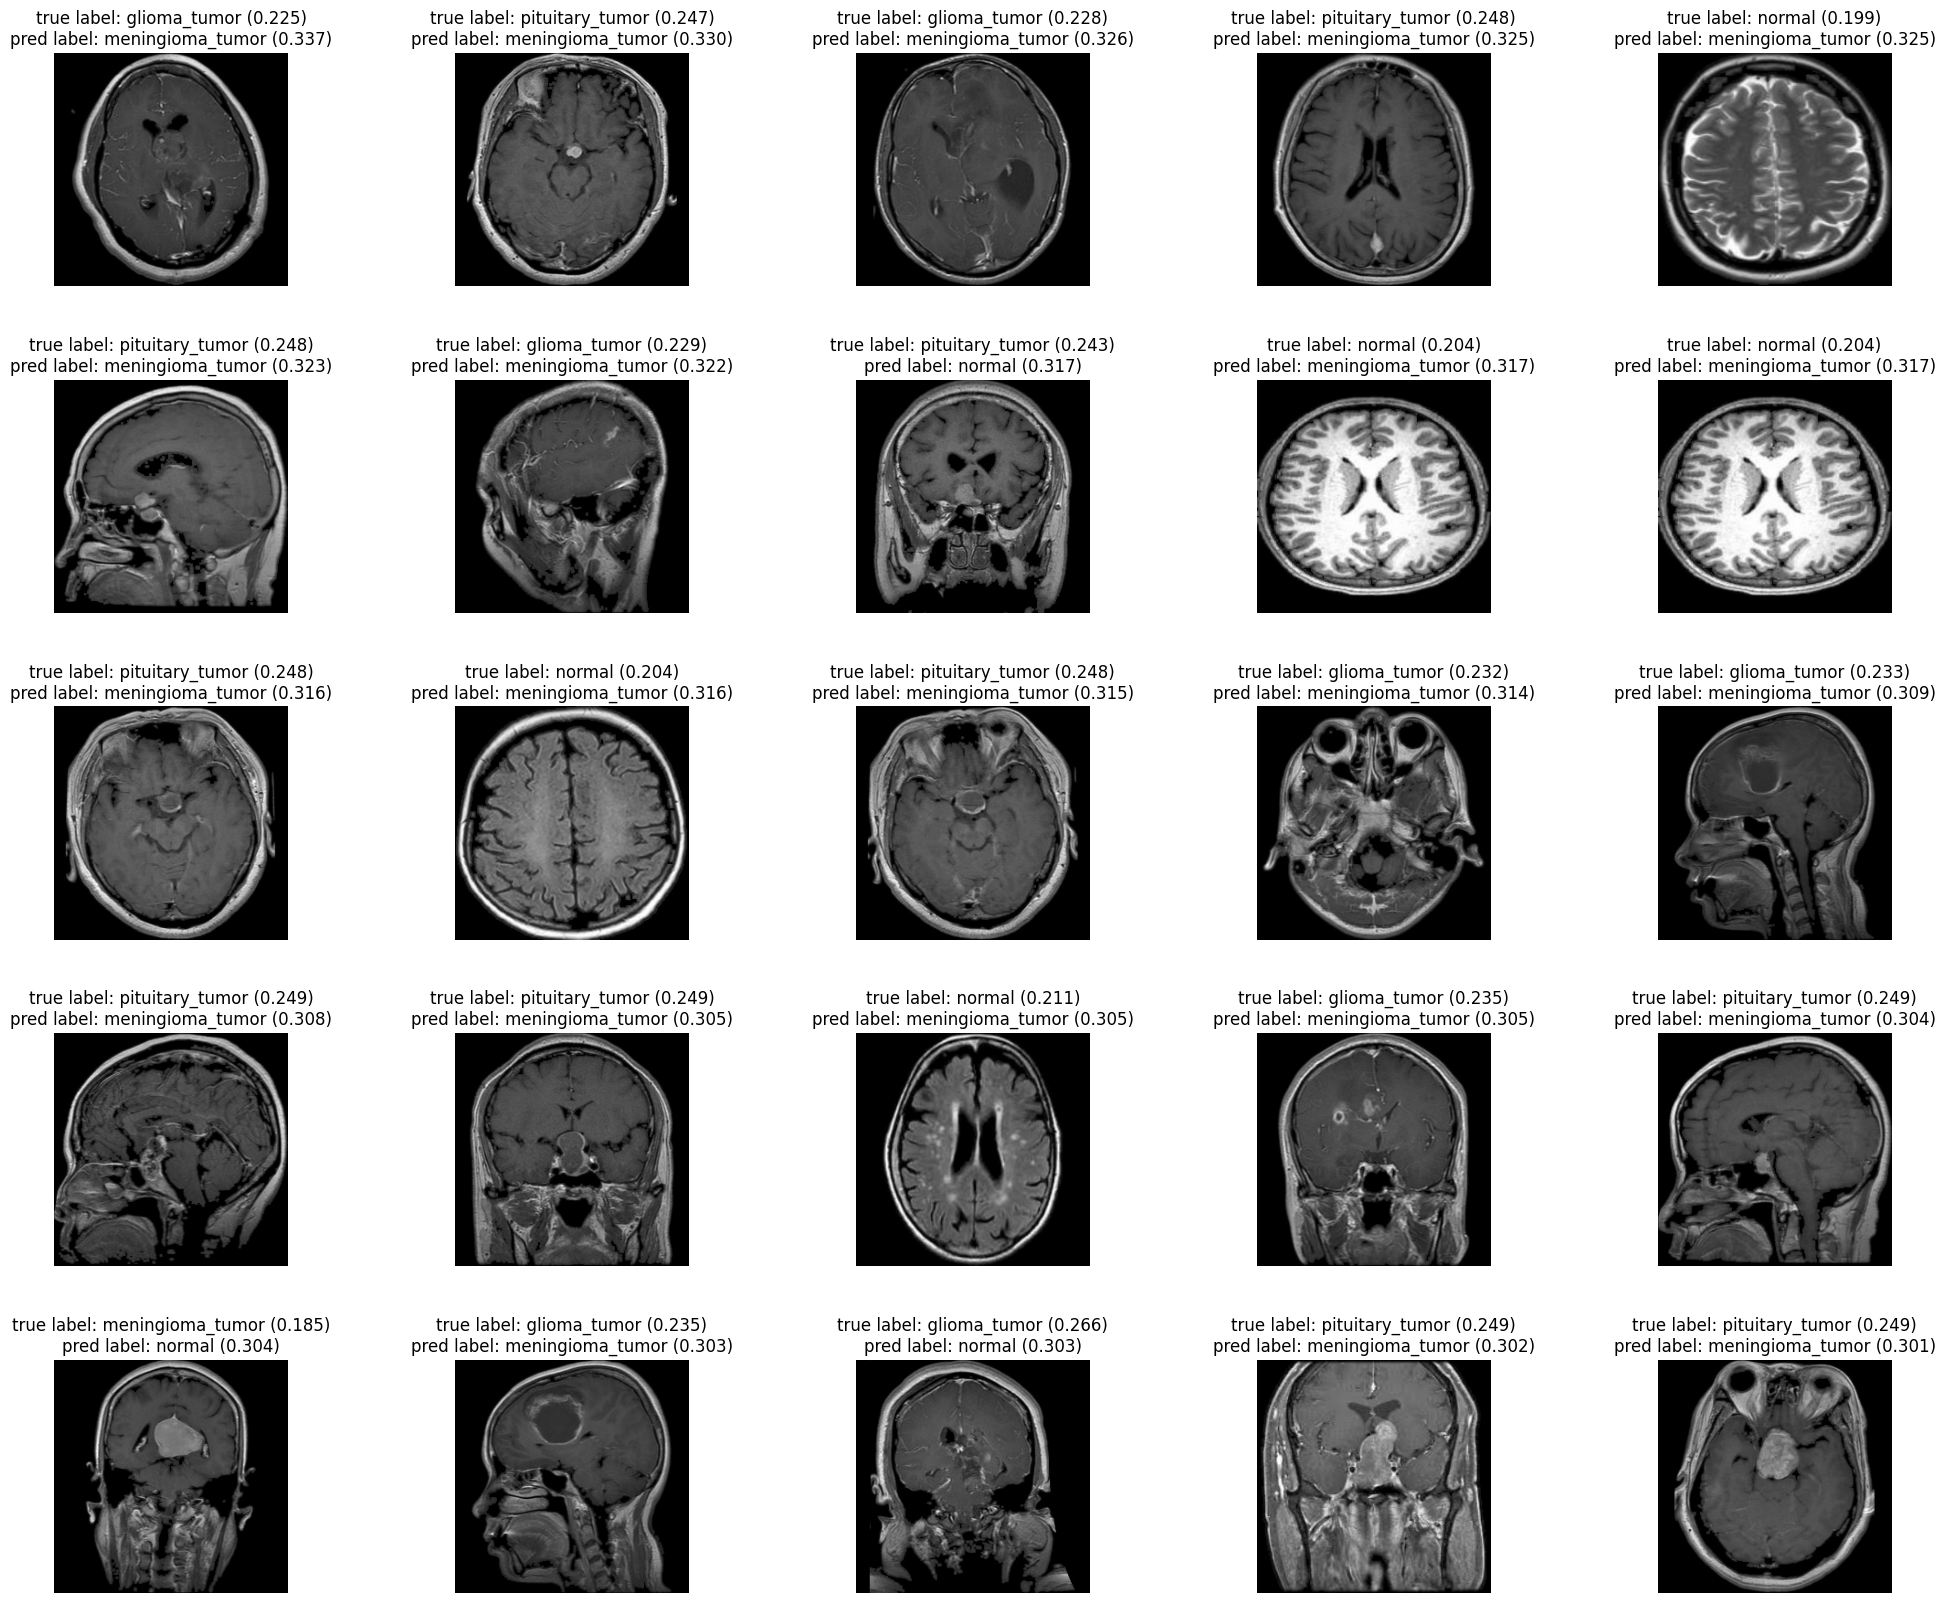

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [ ]:
def get_representations(model, iterator, device):
    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for (x, y) in tqdm(iterator):
            x = x.to(device)
            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [ ]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/70 [00:00<?, ?it/s]

In [ ]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, classes, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

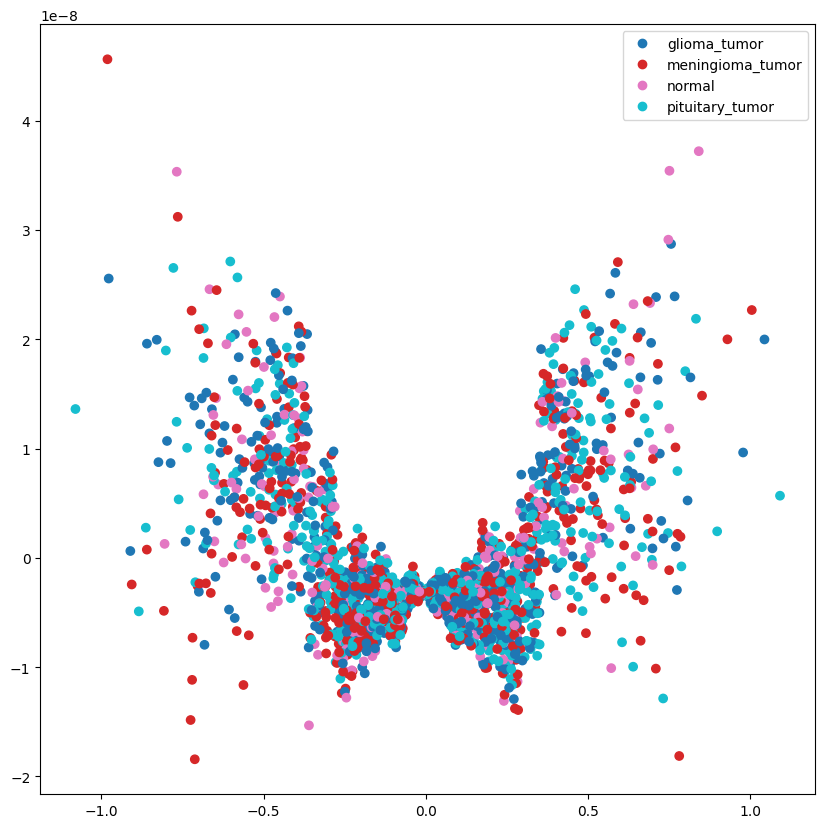

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

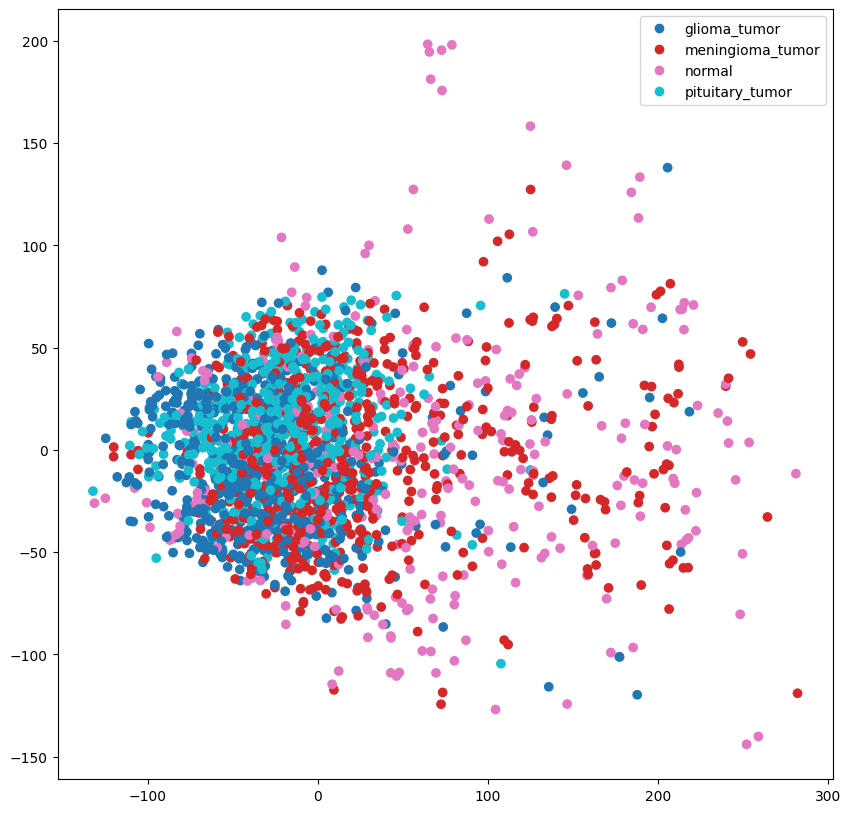

In [ ]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels, classes)

In [ ]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

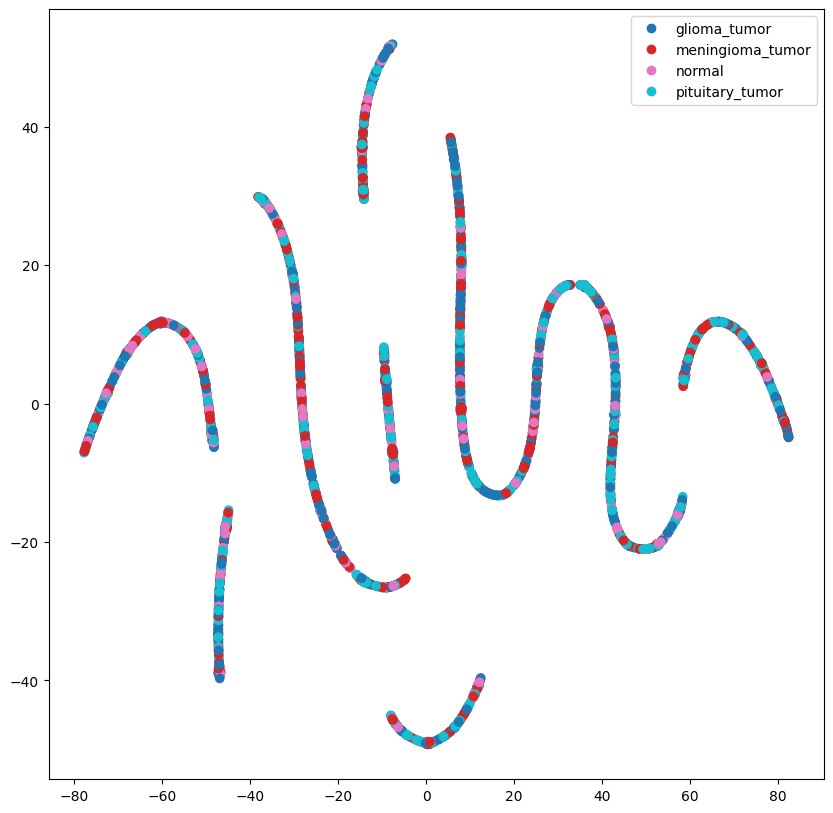

In [ ]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images=N_IMAGES)

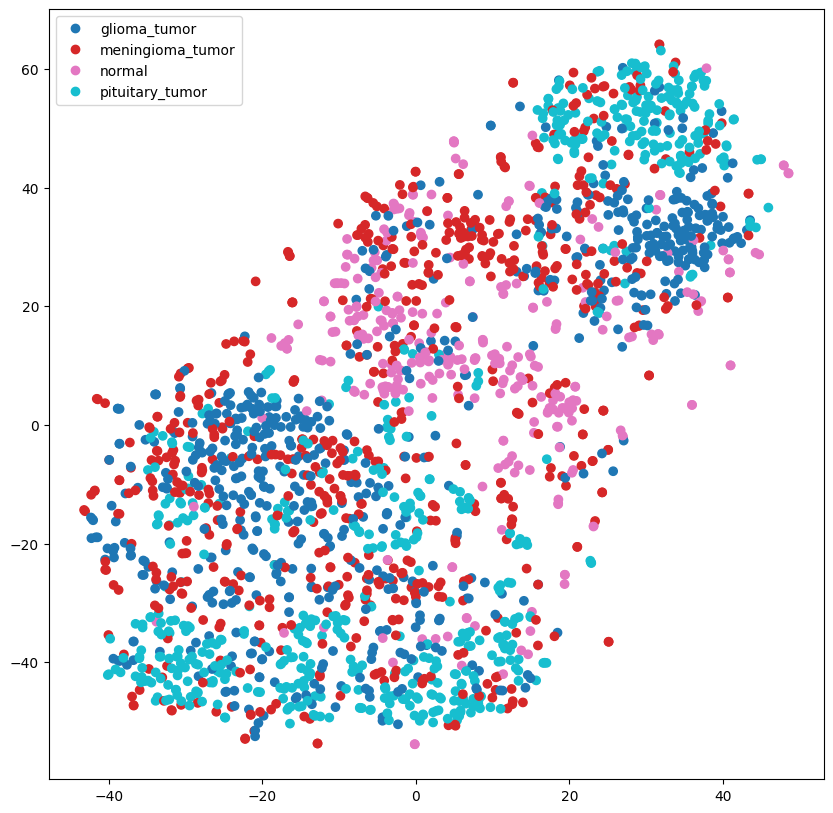

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, classes, n_images=N_IMAGES)